# 03.1 The Most Dangerous Equation: Standard Error

**Chapter**: 3 - Stats Review  
**Section**: 1 - Standard Error  
**Facure Source**: 03-Stats-Review-The-Most-Dangerous-Equation.ipynb  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [Why "Dangerous"?](#11-why-dangerous)
   - 1.2 [The School Size Paradox](#12-the-school-size-paradox)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Moivre's Equation](#21-moivres-equation)
   - 2.2 [SE of Treatment Effects](#22-se-of-treatment-effects)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [The Triangular Plot](#31-the-triangular-plot)
   - 3.2 [SE in A/B Tests](#32-se-in-ab-tests)
4. [Implementation](#4-implementation)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()
np.random.seed(42)

---

## 1. Facure's Intuition

> **Interview Relevance**: Understanding standard error is fundamental to statistical inference. Interviewers often test whether you understand the relationship between sample size and precision.

### 1.1 Why "Dangerous"?

Howard Wainer (2007) called Moivre's equation the "most dangerous equation" because:
- **Dangerous if you DON'T know it**: You'll make terrible decisions
- People forget that estimates from small samples are **noisy**
- This leads to over-interpretation of random variation

### 1.2 The School Size Paradox

Facure's example: Looking at ENEM scores (Brazilian SAT):
- **Top-performing schools are small**
- Conclusion: Small schools are better? Fund school size reduction?

**But wait**: Bottom-performing schools are ALSO small!

Why? **Small sample variance**. With few students:
- More extreme averages by chance
- Both extremely high AND extremely low

★ Insight ─────────────────────────────────────
- Small samples have high variance in estimates
- This creates "triangular" scatter plots
- Large samples converge toward population mean
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Moivre's Equation

$$\boxed{SE = \frac{\sigma}{\sqrt{n}}}$$

where:
- $SE$ = standard error of the mean
- $\sigma$ = population standard deviation
- $n$ = sample size

**Key implications**:

1. **SE decreases with $\sqrt{n}$**: To halve SE, you need 4× the sample

2. **Diminishing returns**: Going from n=100 to n=1000 helps more than n=1000 to n=10000

3. **Sample variance estimate**:
$$\hat{\sigma} = \sqrt{\frac{1}{n-1}\sum_{i=1}^n (x_i - \bar{x})^2}$$

### 2.2 SE of Treatment Effects

For difference in means $\hat{\tau} = \bar{Y}_1 - \bar{Y}_0$:

$$SE(\hat{\tau}) = \sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_0^2}{n_0}}$$

This is the **Neyman variance formula** (1923)—foundation of experimental inference.

---

## 3. Numeric Demonstration

### 3.1 The Triangular Plot

In [2]:
# Simulate school data
np.random.seed(42)
n_schools = 500

# Each school has different number of students
school_sizes = np.random.exponential(100, n_schools).astype(int) + 10

# True mean is the same for all schools (no real school effect)
true_mean = 75
student_std = 15

# Calculate observed school averages
school_means = [np.random.normal(true_mean, student_std, size).mean() 
                for size in school_sizes]

schools = pd.DataFrame({
    'n_students': school_sizes,
    'avg_score': school_means
})

print("Top 10 schools by average score:")
print(schools.nlargest(10, 'avg_score'))
print("\nBottom 10 schools by average score:")
print(schools.nsmallest(10, 'avg_score'))

Top 10 schools by average score:
     n_students  avg_score
168          14    85.7261
409          19    85.4957
333          22    83.9518
72           10    82.8160
306          82    81.9152
4            26    81.5528
141          39    80.8457
205          10    80.5435
85           49    80.2234
299          18    80.0221

Bottom 10 schools by average score:
     n_students  avg_score
294          23    66.4254
312          12    67.9823
42           13    68.1485
472          14    68.4037
26           32    68.8102
100          13    69.3990
19           44    70.0209
335          14    70.0537
83           16    70.1063
332          11    70.2228


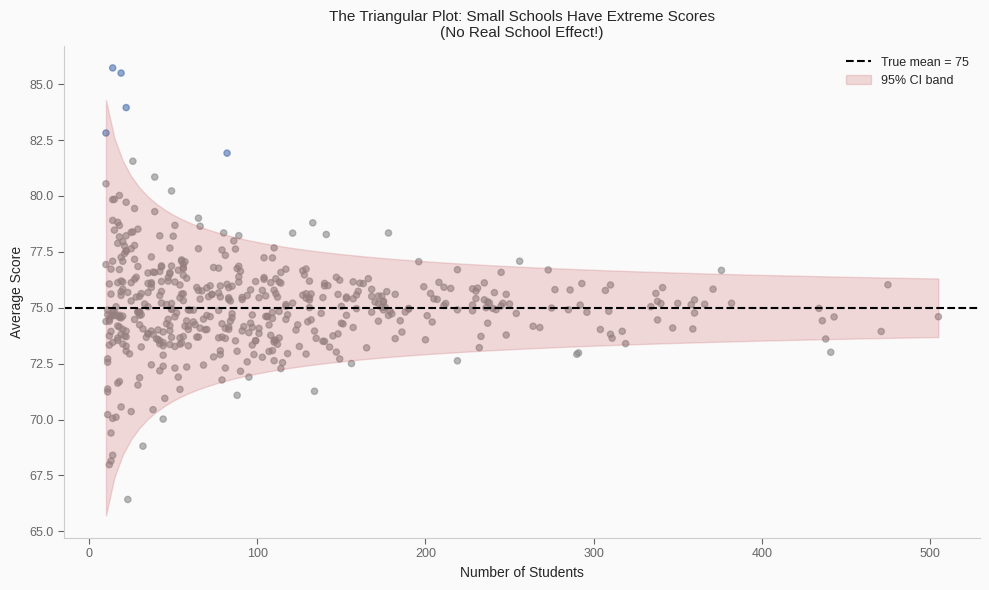


Key insight: BOTH top and bottom schools are small.
This is pure statistical noise, not a school effect!


In [3]:
# The famous triangular plot
fig, ax = create_tufte_figure(1, 1, figsize=(10, 6))

# Color by extreme vs middle
q99 = schools['avg_score'].quantile(0.99)
q01 = schools['avg_score'].quantile(0.01)

colors = np.where(schools['avg_score'] > q99, TUFTE_PALETTE['treatment'],
                  np.where(schools['avg_score'] < q01, TUFTE_PALETTE['control'],
                           TUFTE_PALETTE['secondary']))

ax.scatter(schools['n_students'], schools['avg_score'], 
           c=colors, alpha=0.6, s=20)
ax.axhline(true_mean, color='black', linestyle='--', 
           label=f'True mean = {true_mean}')

# Add SE bands
x_range = np.linspace(10, schools['n_students'].max(), 100)
se_band = 1.96 * student_std / np.sqrt(x_range)
ax.fill_between(x_range, true_mean - se_band, true_mean + se_band,
                alpha=0.2, color=TUFTE_PALETTE['effect'], label='95% CI band')

ax.set_xlabel('Number of Students')
ax.set_ylabel('Average Score')
ax.set_title('The Triangular Plot: Small Schools Have Extreme Scores\n(No Real School Effect!)')
ax.legend(frameon=False)

plt.tight_layout()
plt.show()

print("\nKey insight: BOTH top and bottom schools are small.")
print("This is pure statistical noise, not a school effect!")

### 3.2 SE in A/B Tests

In [4]:
# How sample size affects precision in A/B testing
sample_sizes = [50, 100, 500, 1000, 5000, 10000]
true_effect = 2.0
sigma = 10

results = []
for n in sample_sizes:
    se = sigma * np.sqrt(2/n)  # SE of difference (equal groups)
    ci_width = 2 * 1.96 * se
    results.append({'n': n, 'SE': se, 'CI_width': ci_width})

results_df = pd.DataFrame(results)
print("Sample Size vs. Precision")
print("="*50)
print(results_df.to_string(index=False))
print(f"\nTrue effect: {true_effect}")
print("Notice: To halve CI width, need 4× sample size!")

Sample Size vs. Precision
    n     SE  CI_width
   50 2.0000    7.8400
  100 1.4142    5.5437
  500 0.6325    2.4792
 1000 0.4472    1.7531
 5000 0.2000    0.7840
10000 0.1414    0.5544

True effect: 2.0
Notice: To halve CI width, need 4× sample size!


---

## 4. Implementation

```python
from causal_inference.rct import simple_ate

# SE is automatically computed
result = simple_ate(outcome, treatment)
print(f"ATE: {result.ate:.3f}")
print(f"SE:  {result.se:.3f}")
print(f"n required for SE=0.5: {(sigma/0.5)**2}")
```

---

## 5. Interview Appendix

**Q1**: *"How does sample size affect statistical precision?"*

<details><summary>Solution</summary>

SE = σ/√n, so precision grows with √n. To halve SE, need 4× sample. Diminishing returns: first 100 samples help more than next 100.

</details>

**Q2**: *"Why might the 'best' and 'worst' performers both have small samples?"*

<details><summary>Solution</summary>

Small samples have high variance. By chance, some will be very high, others very low. This is the school size paradox—no real effect, just noise.

</details>

**Q3**: *"How would you calculate SE for a difference in means?"*

<details><summary>Solution</summary>

SE(diff) = √(σ₁²/n₁ + σ₂²/n₀). This is the Neyman variance formula. Variances add because independent samples.

</details>

---

## 6. References

[^1]: Wainer, H. (2007). The Most Dangerous Equation. *American Scientist*, 95(3), 249-256.

[^2]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 3.

[^3]: Neyman, J. (1923). On the Application of Probability Theory to Agricultural Experiments.